# Toy model evaluation of FE estimation and clustering 

In [1]:
import numpy as np
import toy_models
import GMM_FE
import matplotlib.pyplot as plt

In [142]:
toy_model = 'GMM_2D'

x_lims = [[0,1],[0,1]]
stack_landscapes=False
# Create model
if toy_model == 'mGMMs':
    tm = toy_models.MultipleGMMs()
elif toy_model == 'digits':
    tm = toy_models.Digits()
    x_lims = [[-30,30],[-30,30]]
elif toy_model == 'nonlinear_GMM_2D':
    tm = toy_models.GMM2dNonlinear()
    x_lims = [[-1.5,0.5],[-4,1.75]]
else:
    tm = toy_models.GMM2D()

nx = 30

Density grid shape: (30, 30)
Clustering free energy landscape...
Computing Hessians.
Constructing connected components.
# Graph connections: 18716.0
Clustering data points.
Cluster labels: [0. 1. 2. 3. 4. 5. 6. 7.]
Assigning cluster indices to non-core cluster points.
Done clustering.


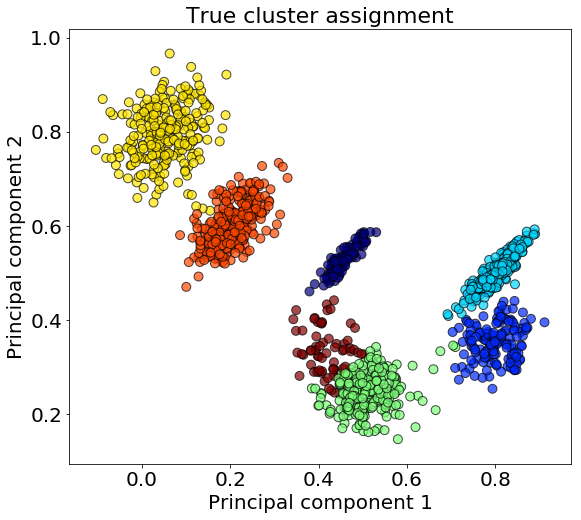

In [144]:
# Sample from model
data = tm.sample(1500)

# Compute true density at points
data_density = tm.density(data)

# Get cluster labels
if hasattr(tm,"assign_cluster_labels"):
    labels = tm.assign_cluster_labels(data)
else:
    true_fe = GMM_FE.FreeEnergy(data,x_lims=x_lims,n_grids=nx,verbose=False,stack_landscapes=stack_landscapes)
    true_fe.density_est_ = tm
    coords, density = true_fe.density_landscape()

    # Compute true free energy
    FE_landscape = true_fe._free_energy(density)
    min_FE = np.min(FE_landscape)
    FE_landscape = FE_landscape-min_FE

    FE_points = true_fe._free_energy(data_density)-min_FE

    # Set true free energies
    true_fe.coords_ = coords
    true_fe.FE_landscape_ = FE_landscape
    true_fe.FE_points_ = FE_points
    #labels, cluster_centers = true_fe.cluster(coords,FE_points,data,assign_transition_points=True)
    labels, cluster_centers = true_fe.cluster(data,FE_points,assign_transition_points=True)

plt.figure(1,figsize=(9,8))
plt.scatter(data[:,0],data[:,1],c=labels,alpha=0.7,cmap='jet',edgecolor='k',s=80)
#plt.scatter(data[:,0],data[:,1],c=tm.labels_,alpha=0.7,cmap='jet',edgecolor='k',s=80)
plt.xlabel('Principal component 1',fontsize=20)
plt.ylabel('Principal component 2',fontsize=20)
plt.title('True cluster assignment',fontsize=22)
plt.savefig(toy_model+'_true_clustering.svg')
plt.show()

Density grid shape: (30, 30)


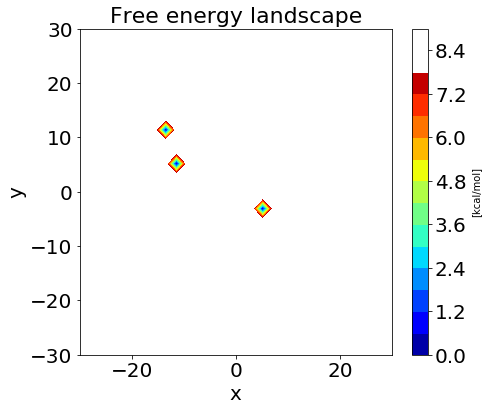

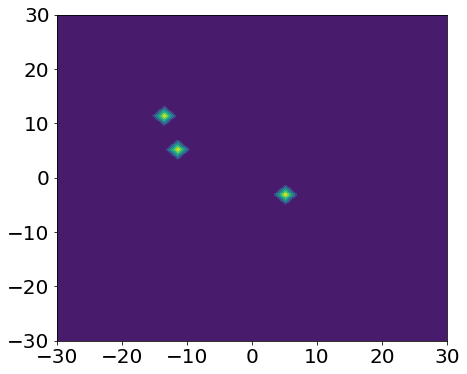

In [107]:
# Create a free energy object with known toy model
true_fe = GMM_FE.FreeEnergy(data,x_lims=x_lims,n_grids=nx,verbose=False,stack_landscapes=stack_landscapes)
true_fe.density_est_ = tm
coords, density = true_fe.density_landscape()

# Compute true free energy
FE_landscape = true_fe._free_energy(density)
min_FE = np.min(FE_landscape)
FE_landscape = FE_landscape-min_FE

FE_points = true_fe._free_energy(data_density)-min_FE

# Set true free energies
true_fe.coords_ = coords
true_fe.FE_landscape_ = FE_landscape
true_fe.FE_points_ = FE_points

# Visualize the model
true_fe.visualize(show_data=False,vmax=8)

plt.figure(2)
plt.contourf(coords[0],coords[1],np.exp(-FE_landscape/(true_fe.temperature_*true_fe.boltzmann_constant)))

In [108]:
# Cluster data
if hasattr(tm,"assign_cluster_labels"):
    labels = tm.assign_cluster_labels(data)
    true_fe.labels_=labels
else:
    #labels, cluster_centers = true_fe.cluster(coords,FE_points,data,assign_transition_points=True)
    labels, cluster_centers = true_fe.cluster(data,FE_points,assign_transition_points=True)

[ 257 1032 1263  292  654 1142  671]


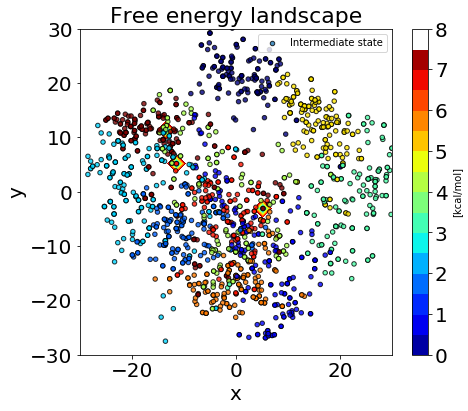

In [109]:
# Visualize true clusters
true_fe.visualize(show_data=True)
#plt.scatter(true_fe.cl_.grid_points_[:,0],true_fe.cl_.grid_points_[:,1],c=true_fe.is_FE_min)
plt.savefig(toy_model+'_true_clustering.svg')
print(cluster_centers)

In [7]:
# Estimate free energy and clustering with GMM and cross-validation
stack_landscapes = False

gmm_FE = GMM_FE.FreeEnergy(data,min_n_components=2,max_n_components=12, n_components_step=1, x_lims=true_fe.x_lims_, 
                           n_grids=true_fe.nx_, stack_landscapes=stack_landscapes, n_iterations=7, convergence_tol=1e-7, n_splits=1)

est_coords, est_FE_landscape, est_FE_points = gmm_FE.landscape()

*----------------Gaussian mixture model free energy estimator----------------*
   n_splits = 1
   shuffle_data = False
   n_iterations = 7
   n_grids = 30
   covergence_tol = 1e-07
   stack_landscapes = False
   x_lims (axes limits) = [[-1.5, 0.5], [-8, 1.75]]
   temperature = 300.0
   min_n_components = 2
   max_n_components = 12
   n_components_step = 1
*----------------------------------------------------------------------------*
Estimating density with GMM.
# Components = 2
# Components = 3


/home/anniewe/program/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


# Components = 4
# Components = 5
# Components = 6
# Components = 7
# Components = 8
# Components = 9
# Components = 10
# Components = 11
# Components = 12
Identifying final model with 4 components.
Evaluating density in landscape
Density grid shape: (30, 30)


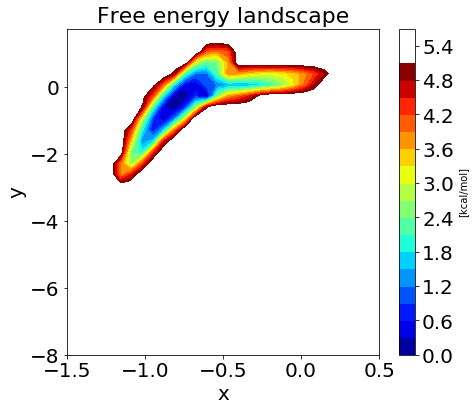

In [8]:
# Visualize estimated free energy landscape and the true free energy contours
gmm_FE.visualize(show_data=False,vmax=5,n_contour_levels=20)

if stack_landscapes:
    # Plot the model weights
    plt.figure(2)
    plt.plot(gmm_FE.density_est_.n_components_list_,gmm_FE.density_est_.model_weights_,linewidth=2,marker='o',color=[0.56,0.56,0.6],markersize=10)
    
    # Plot each indivudual model
    n_models = gmm_FE.density_est_.n_models_
    for i_model in range(n_models):
        # Create a free energy object with known toy model
        mod_fe = GMM_FE.FreeEnergy(data,x_lims=true_fe.x_lims_,n_grids=true_fe.nx_,verbose=False)
        mod_fe.density_est_ = gmm_FE.density_est_.GMM_list_[i_model]
        mod_coords, density = mod_fe.density_landscape()
        
        # Compute true free energy
        mod_FE_landscape = mod_fe._free_energy(density)
        mod_min_FE = np.min(mod_FE_landscape)
        mod_FE_landscape = mod_FE_landscape-mod_min_FE

        # Set true free energies
        mod_fe.coords_ = mod_coords
        mod_fe.FE_landscape_ = mod_FE_landscape

        # Visualize the model
        mod_fe.visualize(show_data=True)

In [9]:
# Cluster based on estimated density model
est_labels, est_cluster_centers = gmm_FE.cluster(data,est_FE_points,assign_transition_points=True)

Clustering free energy landscape...
Computing Hessians.
Constructing connected components.
# Graph connections: 109552.0
Clustering data points.
Cluster labels: [0. 1. 2. 3.]
Assigning cluster indices to non-core cluster points.
Done clustering.


[2619 2292  318]
[2619 2292  318]
4


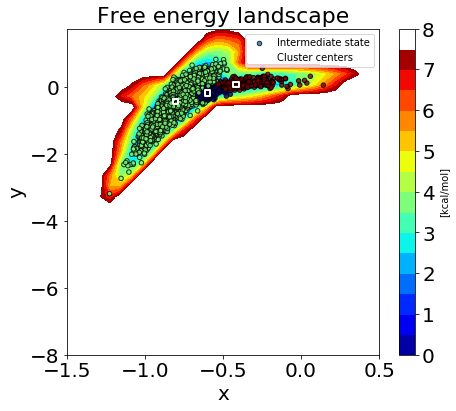

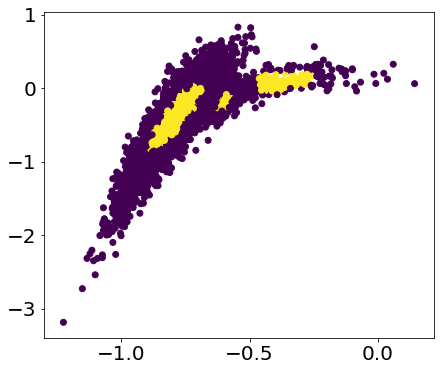

In [10]:
print(gmm_FE.cluster_centers_)
gmm_FE.visualize(show_data=True)

plt.figure(2)
plt.scatter(gmm_FE.cl_.grid_points_[:,0],gmm_FE.cl_.grid_points_[:,1],c=gmm_FE.is_FE_min)
print(est_cluster_centers)
if not(stack_landscapes):
    print(gmm_FE.density_est_.n_components_)

# Evaluate clustering methods on toy models

In [5]:
# Evaluate each toy_model
toy_model_list = ['nonlinear_GMM_2D','GMM_2D','mGMMs','digits']

tm_evals = []
for toy_model in toy_model_list:
    te = toy_models.MethodEvaluator(convergence_tol=1e-7,toy_model=toy_model,verbose=False)
    te.run_evaluation(50, 4000, n_iterations=7, min_n_components=2, max_n_components=20, n_splits=1, save_data=False)
    tm_evals.append(te)

Setting true model.
Density grid shape: (30, 30)
Run: 1/50
Estimating density with GMM.


/home/anniewe/program/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Identifying final model with 4 components.
Evaluating density in landscape
Density grid shape: (30, 30)
Clustering free energy landscape...
Computing Hessians.
Constructing connected components.
# Graph connections: 99938.0
Clustering data points.
Cluster labels: [0. 1. 2. 3. 4.]
Assigning cluster indices to non-core cluster points.
Done clustering.
Cluster data with K-means
Cluster labels: [1 2]
Cluster data with agglomerative-Ward
Cluster labels: [1 2]
Cluster data with spectral clustering
Spectral embedding
Cluster data with 2 clusters.
Cluster labels: [1 2]
Run: 2/50
Estimating density with GMM.
Identifying final model with 4 components.
Evaluating density in landscape
Density grid shape: (30, 30)
Clustering free energy landscape...
Computing Hessians.
Constructing connected components.
# Graph connections: 90216.0
Clustering data points.
Cluster labels: [0. 1. 2. 3. 4.]
Assigning cluster indices to non-core cluster points.
Done clustering.
Cluster data with K-means
Cluster labels:

/home/anniewe/program/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


Identifying final model with 11 components.
Evaluating density in landscape
Density grid shape: (30, 30)
Clustering free energy landscape...
Computing Hessians.
Constructing connected components.
# Graph connections: 87251.0
Clustering data points.
Cluster labels: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
Assigning cluster indices to non-core cluster points.
Done clustering.
Cluster data with K-means
Cluster labels: [1 2 3 4]
Cluster data with agglomerative-Ward
Cluster labels: [1 2 3]
Cluster data with spectral clustering
Spectral embedding
Cluster data with 3 clusters.
Cluster labels: [1 2 3]
Run: 4/50
Estimating density with GMM.
Identifying final model with 10 components.
Evaluating density in landscape
Density grid shape: (30, 30)
Clustering free energy landscape...
Computing Hessians.
Constructing connected components.
# Graph connections: 75598.0
Clustering data points.
Cluster labels: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Assigning cluster indices to

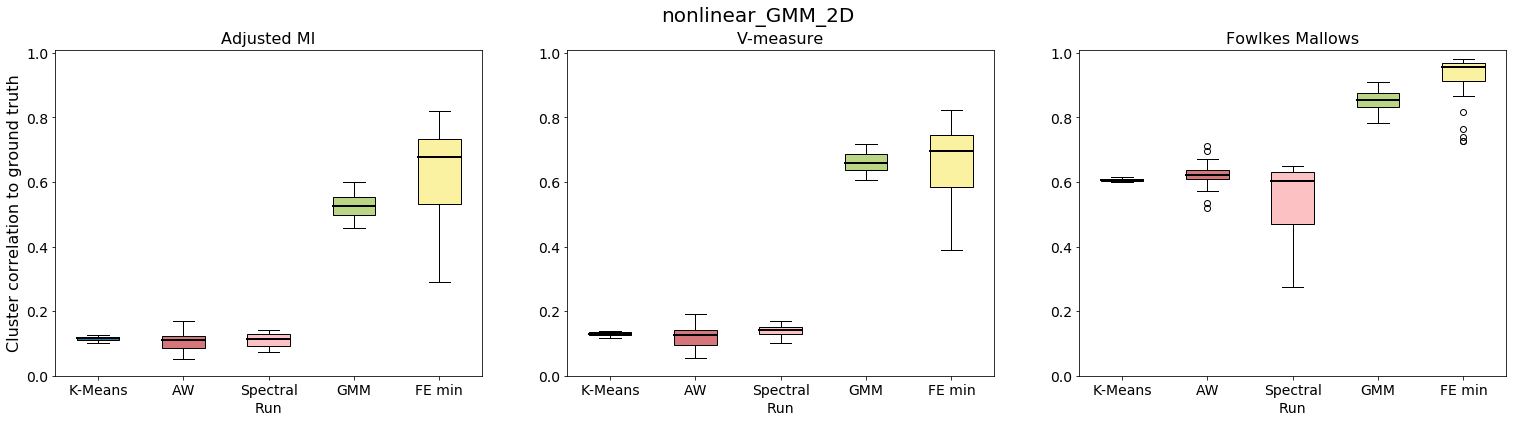

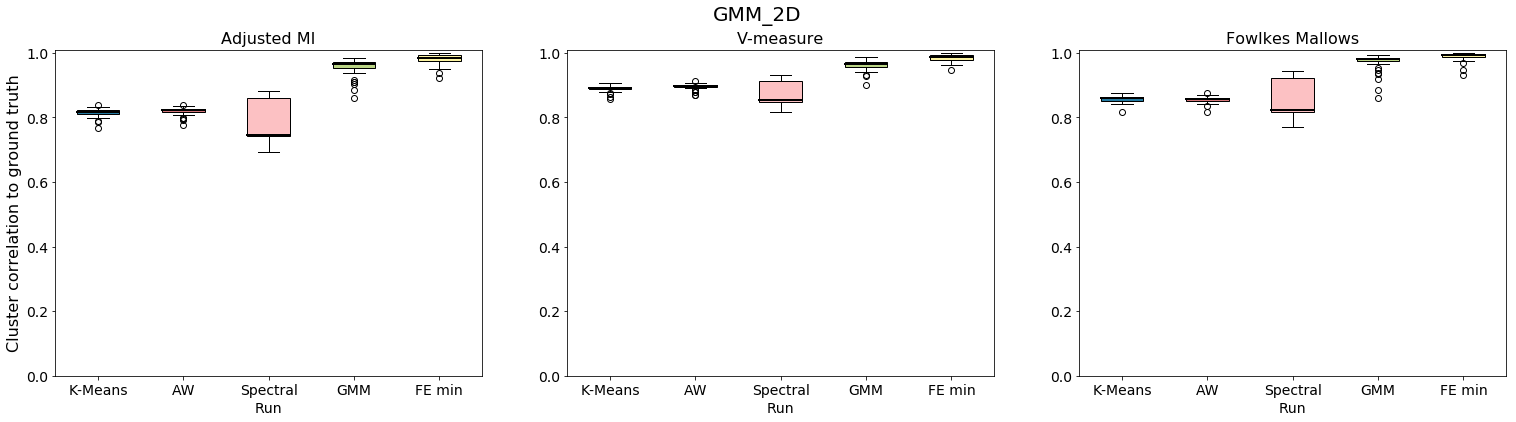

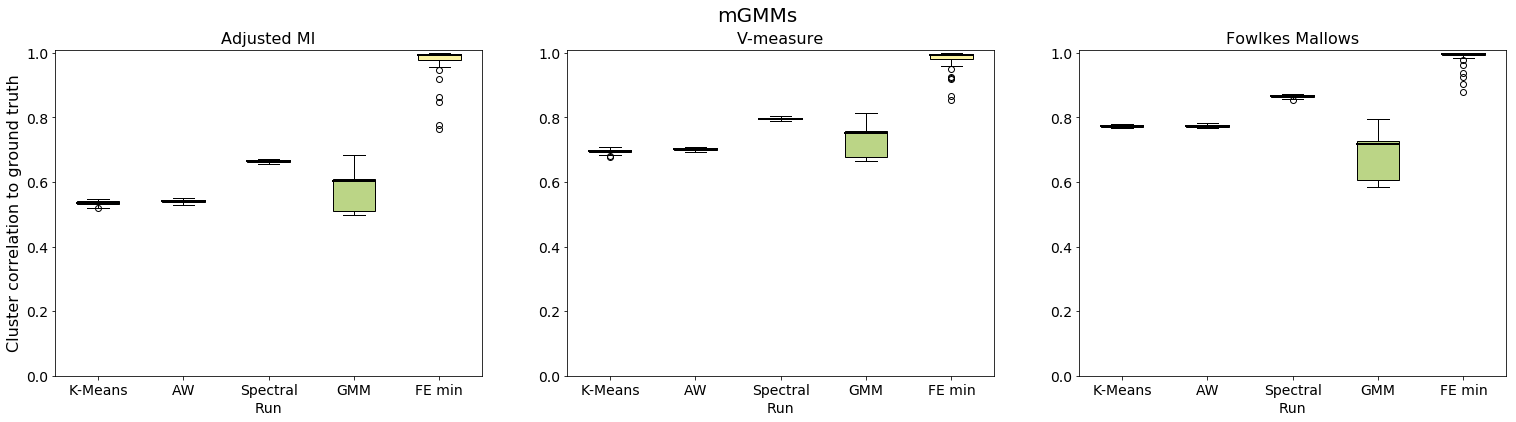

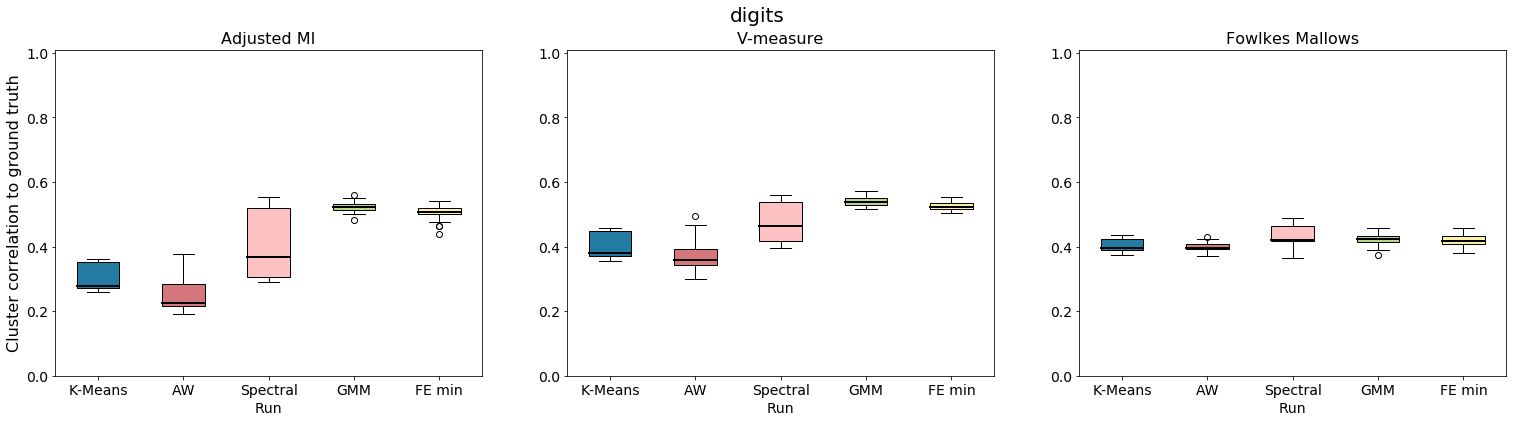

In [76]:
counter=1
n_runs=50
alpha=0.5
show_data=False
facecolors = [[0.141,0.482,0.637],[0.837,0.463,0.478],[0.99,0.757,0.765],[0.733,0.837,0.525],[0.98,0.949,0.631]]

for te in tm_evals:
    fig=plt.figure(counter,figsize=(26,6))
    ax = fig.add_subplot(131) 
    medianprops = dict(color='k',linewidth=2)
    boxprops = dict(color='k',linewidth=1,facecolor=[0.87,0.9,0.9])
    bp=ax.boxplot([te.cluster_score_ami_kmeans_,te.cluster_score_ami_AW_,te.cluster_score_ami_spectral_,te.cluster_score_ami_GMM_,te.cluster_score_ami_GMM_FE_min_],
               notch=False, medianprops=medianprops, boxprops=boxprops,labels=['K-Means','AW','Spectral','GMM','FE min'],patch_artist=True)
    
    
    counter2=0
    for patch in bp['boxes']:
        patch.set(facecolor=facecolors[counter2],alpha=1) 
        counter2+=1
    if show_data:
        plt.scatter(1*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_ami_kmeans_,label="K-means clusters",s=40,alpha=alpha,color=facecolors[0])
        plt.scatter(2*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_ami_AW_,label="Ward clusters",s=40,alpha=alpha,color=facecolors[1])
        plt.scatter(3*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_ami_spectral_,label="Spectral clusters",s=40,alpha=alpha,color=facecolors[2])
        plt.scatter(4*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_ami_GMM_,label="GMM clusters",s=40,alpha=alpha,color=facecolors[3])
        plt.scatter(5*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_ami_GMM_FE_min_,label="FE min clusters",s=40,alpha=alpha,color=facecolors[4])
    plt.title('Adjusted MI',fontsize=16)
    plt.xlabel("Run",fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.ylabel("Cluster correlation to ground truth",fontsize=16)
    plt.ylim([0,1.01])
    
    ax = fig.add_subplot(132) 
    medianprops = dict(color='k',linewidth=2)
    boxprops = dict(color='k',linewidth=1,facecolor=[0.87,0.9,0.9])
    bp=ax.boxplot([te.cluster_score_vm_kmeans_,te.cluster_score_vm_AW_,te.cluster_score_vm_spectral_,te.cluster_score_vm_GMM_,te.cluster_score_vm_GMM_FE_min_],
               notch=False, medianprops=medianprops, boxprops=boxprops,labels=['K-Means','AW','Spectral','GMM','FE min'],patch_artist=True)
    
    counter2=0
    for patch in bp['boxes']:
        patch.set(facecolor=facecolors[counter2],alpha=1) 
        counter2+=1
    
    if show_data:
        plt.scatter(1*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_vm_kmeans_,label="K-means clusters",s=40,alpha=alpha,color=facecolors[0])
        plt.scatter(2*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_vm_AW_,label="Ward clusters",s=40,alpha=alpha,color=facecolors[1])
        plt.scatter(3*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_vm_spectral_,label="Spectral clusters",s=40,alpha=alpha,color=facecolors[2])
        plt.scatter(4*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_vm_GMM_,label="GMM clusters",s=40,alpha=alpha,color=facecolors[3])
        plt.scatter(5*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_vm_GMM_FE_min_,label="FE min clusters",s=40,alpha=alpha,color=facecolors[4])
    plt.title('V-measure',fontsize=16)
    plt.xlabel("Run",fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.ylim([0,1.01])
    
    ax = fig.add_subplot(133)
    medianprops = dict(color='k',linewidth=2)
    boxprops = dict(color='k',linewidth=1,facecolor=[0.87,0.9,0.9])
    bp=ax.boxplot([te.cluster_score_fm_kmeans_,te.cluster_score_fm_AW_,te.cluster_score_fm_spectral_,te.cluster_score_fm_GMM_,te.cluster_score_fm_GMM_FE_min_],
               notch=False, medianprops=medianprops, boxprops=boxprops,labels=['K-Means','AW','Spectral','GMM','FE min'],patch_artist=True)
    
    counter2=0
    for patch in bp['boxes']:
        patch.set(facecolor=facecolors[counter2],alpha=1) 
        counter2+=1
    if show_data:
        plt.scatter(1*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_fm_kmeans_,label="K-means clusters",s=40,alpha=alpha,color=facecolors[0])
        plt.scatter(2*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_fm_AW_,label="Ward clusters",s=40,alpha=alpha,color=facecolors[1])
        plt.scatter(3*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_fm_spectral_,label="Spectral clusters",s=40,alpha=alpha,color=facecolors[2])
        plt.scatter(4*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_fm_GMM_,label="GMM clusters",s=40,alpha=alpha,color=facecolors[3])
        plt.scatter(5*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_fm_GMM_FE_min_,label="FE min clusters",s=40,alpha=alpha,color=facecolors[4])
    plt.title('Fowlkes Mallows',fontsize=16)
    counter+=1
    #plt.legend(fontsize=16)
    plt.ylim([0,1.01])
    plt.suptitle(te.toy_model_.name,fontsize=20)
    plt.xlabel("Run",fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)

    plt.savefig(te.toy_model_.name+'.svg')